In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import feather
import warnings
import time
import sys
import datetime

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 1000)
from scipy.stats import mode
from scipy import stats
from sklearn import preprocessing

import re
import gc
from IPython.core.display import display, HTML

In [2]:
last_two_month = feather.read_dataframe('last_two_months')

In [16]:
def modeplus(x): return mode(x)[0]
def count_non_zero(x): return x.astype(np.bool_).sum()
def non_zero_percent(x): return x.astype(np.bool_).sum() / x.size
def top_quarter_quantile(x): return x.quantile(q=0.1)
def bottom_quarter_quantile(x): return x.quantile(q=0.9)

In [17]:
agg_pars = {'authorized_flag':['mean','size','sum'],
            'city_id':[modeplus,'median'],
            'category_1':['mean','sum'],
            'installments':['sum','max','min',count_non_zero,'mean',bottom_quarter_quantile,top_quarter_quantile],
            'merchant_category_id':[modeplus,'median'],
            'purchase_amount':['mean','max','min','sum'],
            'state_id':[modeplus,'count'],
            'subsector_id':modeplus,'no_city':'mean',
            'undefined_installments':['sum','mean'],
            'big_installments':['mean','sum'],
            'cat2_dum_0.0':['mean','sum'],
            'cat2_dum_1.0':['mean','sum'],
            'cat2_dum_2.0':['mean','sum'],
            'cat2_dum_3.0':['mean','sum'],
            'cat2_dum_4.0':['mean','sum'],
            'cat2_dum_5.0':['mean','sum'],
            'cat2_dum_nan':['mean','sum'],
            'cat3_dum_A':['mean','sum'],
            'cat3_dum_B':['mean','sum'],
            'cat3_dum_C':['mean','sum'],
            'cat3_dum_nan':['mean','sum'],
            'purchase_amount_unusual':['mean','sum'],
            'payment_per_month':['mean','max','min',count_non_zero,non_zero_percent,top_quarter_quantile,bottom_quarter_quantile]}

In [19]:
agged_two_months = last_two_month.groupby(['card_id','month_order']).agg(agg_pars)

In [24]:
agged_two_months = agged_two_months.unstack(fill_value=0)

In [47]:
agged_two_months.columns = [f'{x[0]}_{x[1]}_{x[2]}th' for x in agged_two_months.columns.values]

In [50]:
agged_two_months.reset_index(inplace=True)

In [54]:
agged_two_months.rename(mapper={'authorized_flag_size_0th':'size_0th','authorized_flag_size_1th':'size_1th'},inplace=True,axis=1)

In [56]:
agged_two_months['size'] = agged_two_months.size_0th + agged_two_months.size_1th

In [74]:
train = pd.read_csv('C:\\kdata\\train.csv',usecols=['card_id','target'])
test = pd.read_csv('C:\\kdata\\test.csv',usecols=['card_id'])

In [76]:
train = pd.merge(train,agged_two_months,how='left',on='card_id')
test = pd.merge(test,agged_two_months,how='left',on='card_id')

In [78]:
target = train['target']
del train['target']

In [82]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [x for x in train.columns.values if re.search(x,'modeplus')]

In [86]:
outputs = []
ptest = 1
for ptest in range(1):
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 75, #checked
             'min_data_in_leaf': 100, #checked 
             'objective':'regression',
             'max_depth': 9, #checked #9
             'tree_learner':'data',
             'learning_rate': 0.003,
             "boosting": "rf", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5,
             "bagging_fraction": 0.70, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
#             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
             'gpu_use_dp':True,
            }

    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )


        clf = lgb.train(param,
                        trn_data,
                        15000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=1000,
                        early_stopping_rounds = 1000)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    print("CV score: {:<8.5f}".format(errr))
    outputs.append(f'{ptest}, {errr}')
    print(f'\n^ {ptest} - num leaves^ \n')

fold n°0


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.7802	valid_1's rmse: 3.85045
Early stopping, best iteration is:
[901]	training's rmse: 3.78017	valid_1's rmse: 3.85047
fold n°1


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.80011	valid_1's rmse: 3.77325
[2000]	training's rmse: 3.79999	valid_1's rmse: 3.77301
[3000]	training's rmse: 3.79994	valid_1's rmse: 3.77301
Early stopping, best iteration is:
[2581]	training's rmse: 3.79991	valid_1's rmse: 3.77295
fold n°2


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.80496	valid_1's rmse: 3.75052
Early stopping, best iteration is:
[280]	training's rmse: 3.80542	valid_1's rmse: 3.75026
fold n°3


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.75231	valid_1's rmse: 3.95924
Early stopping, best iteration is:
[224]	training's rmse: 3.75218	valid_1's rmse: 3.95873
fold n°4


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.80196	valid_1's rmse: 3.76219
Early stopping, best iteration is:
[710]	training's rmse: 3.80188	valid_1's rmse: 3.76227
CV score: 3.81974 

^ 0 - num leaves^ 



In [87]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

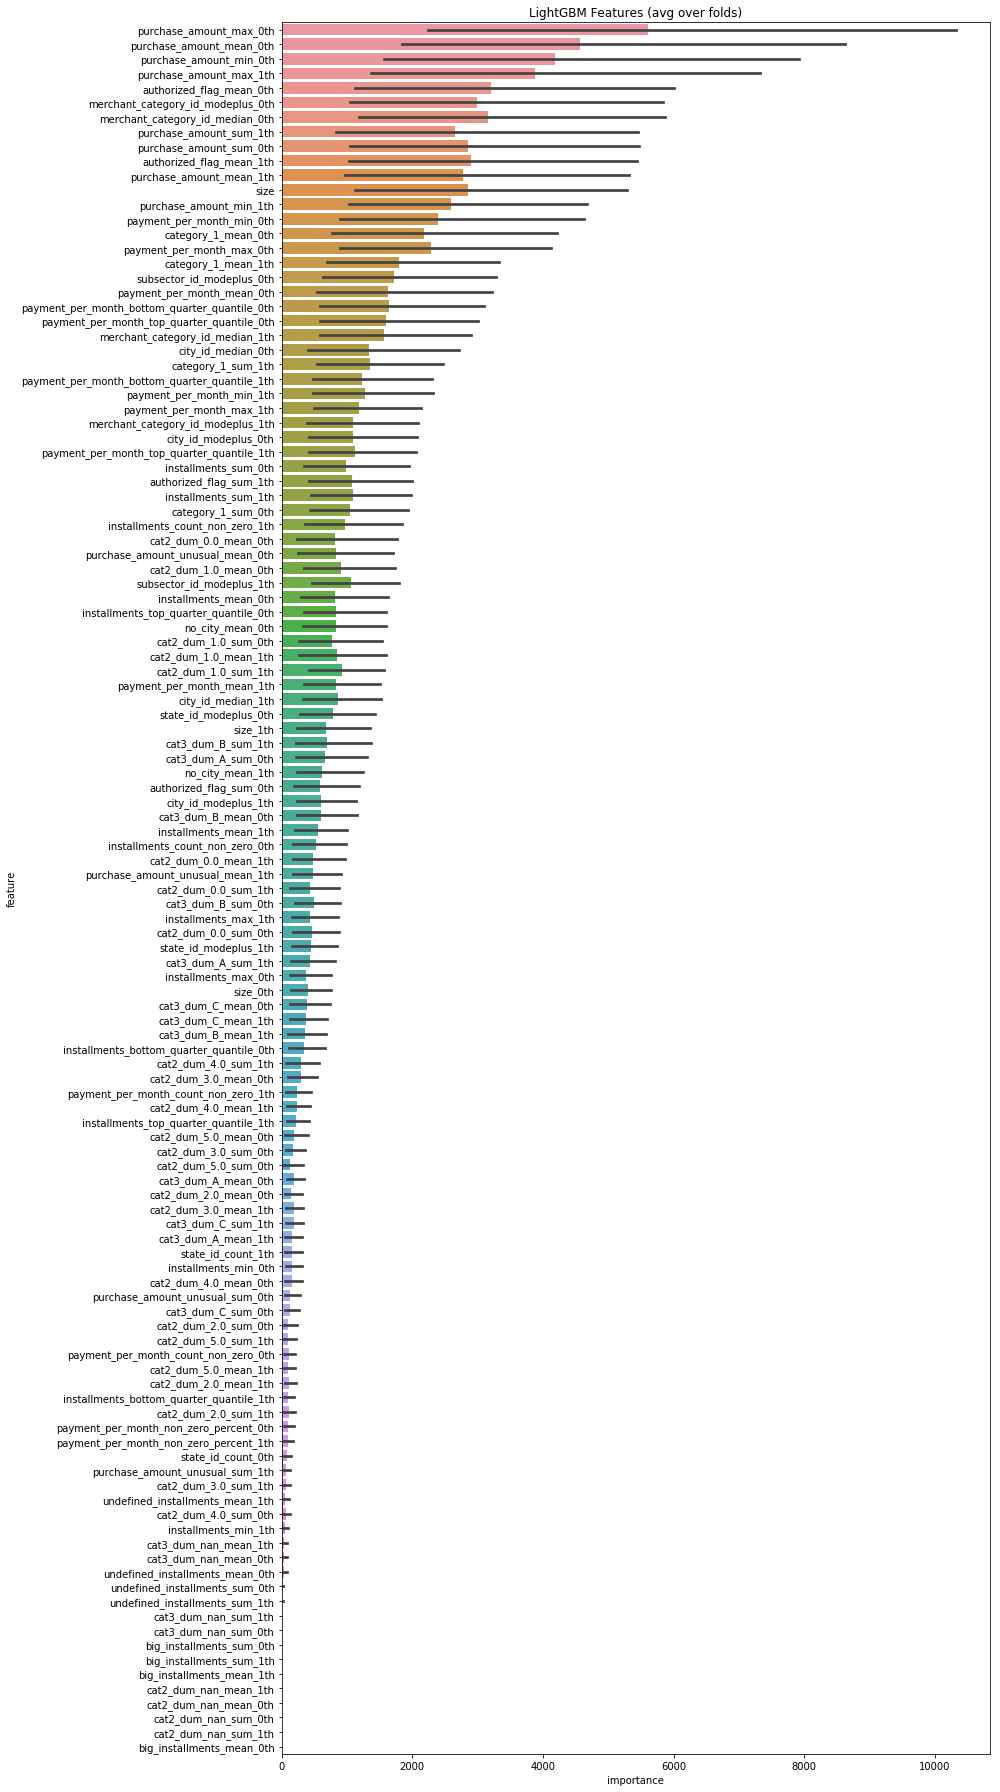

In [88]:
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [89]:
groupped = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean())